## Producing book recommendations 

To ground my learning in a practical problem, I'll be using the [Goodbooks-10k dataset](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/) 

[Goodbooks](https://www.goodbooks.io/)  is an online book recommendation service that pairs readers with their next favourite read. The dataset contains information on 10,000 books from the service’s catalogue, along with ~80,000 reviews generated by site visitors. I’ll use this rich information to try our best to recommend what good books you (or your friends/family) should read next.


### Dataset overview: Brief EDA

I'll be making use of two main files derived from the dataset$^*$;
 
 - **Books_with_tags.csv**: I created this file for the convenience of this train. It contains book_id, title, author, date, etc. data from the original `books.csv` file, along with user tags merged from the `book_tags.csv` and `tags.csv` files. 
 
 
 - **Book_ratings.csv**: This is a subset of the `ratings.csv` file, with a field for the book titles added for convenience. This file contains the important mapping between users and item ratings.
 
The full dataset can be found [here](https://github.com/zygmuntz/goodbooks-10k).

In [37]:
import pandas as pd

In [13]:
# Load the datasets
books_df = pd.read_csv('books.csv')
book_tags_df = pd.read_csv('book_tags.csv')
tags_df = pd.read_csv('tags.csv')
ratings_df = pd.read_csv('ratings.csv')

In [14]:
# Display column names for debugging
print("Books DataFrame columns:", books_df.columns)
print("Book Tags DataFrame columns:", book_tags_df.columns)
print("Tags DataFrame columns:", tags_df.columns)

Books DataFrame columns: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')
Book Tags DataFrame columns: Index(['goodreads_book_id', 'tag_id', 'count'], dtype='object')
Tags DataFrame columns: Index(['tag_id', 'tag_name'], dtype='object')


In [20]:
# Merge book_tags with tags to get tag names
book_tags_merged = pd.merge(book_tags_df, tags_df, left_on='tag_id', right_on='tag_id')

# Aggregate tags for each book
book_tags_aggregated = book_tags_merged.groupby('goodreads_book_id')['tag_name'].apply(list).reset_index()

# Display the first few rows for debugging
print("Aggregated Book Tags DataFrame:", book_tags_aggregated.head())

# Merge with books data
books_with_tags_df = pd.merge(books_df, book_tags_aggregated, left_on='book_id', right_on='goodreads_book_id', how='left')

# Check for the existence of 'goodreads_book_id' before dropping
if 'goodreads_book_id' in books_with_tags_df.columns:
    books_with_tags_df.drop(columns=['goodreads_book_id'], inplace=True)

# Merge ratings with books to get book titles
book_ratings_df = pd.merge(ratings_df, books_df[['book_id', 'title']], on='book_id', how='left')

Aggregated Book Tags DataFrame:    goodreads_book_id                                           tag_name
0                  1  [to-read, fantasy, favorites, currently-readin...
1                  2  [to-read, fantasy, favorites, currently-readin...
2                  3  [to-read, fantasy, favorites, currently-readin...
3                  5  [to-read, fantasy, favorites, currently-readin...
4                  6  [to-read, fantasy, young-adult, fiction, harry...


In [16]:
# Save the dataframes to CSV
books_with_tags_df.to_csv('Books_with_tags.csv', index=False)
print("Books_with_tags.csv created successfully!")

book_ratings_df.to_csv('Book_ratings.csv', index=False)
print("Book_ratings.csv created successfully!")

Books_with_tags.csv created successfully!
Book_ratings.csv created successfully!


In [10]:
books = pd.read_csv('Books_with_tags.csv')
books.head(3)

,book_id,goodreads_book_id_x,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id_y,tag_name
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,1.0,"['to-read', 'fantasy', 'favorites', 'currently..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,2.0,"['to-read', 'fantasy', 'favorites', 'currently..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,3.0,"['to-read', 'fantasy', 'favorites', 'currently..."


In [11]:
print (f'Number of books in dataset: {books.shape[0]}')

Number of books in dataset: 10000


In [34]:
book_ratings = pd.read_csv('Book_ratings.csv')
book_ratings.head(3)

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People


In [35]:
print (f'Number of ratings in dataset: {book_ratings.shape[0]}')

Number of ratings in dataset: 5976479


Let's look at the distribution of the ratings given by users. Here, we see that readers generally are on the kinder end of the rating spectrum, with a far higher proportion of positive reviews (> 3) being given over negative ones (< 3):

Average rating in dataset: 3.9198655261735214


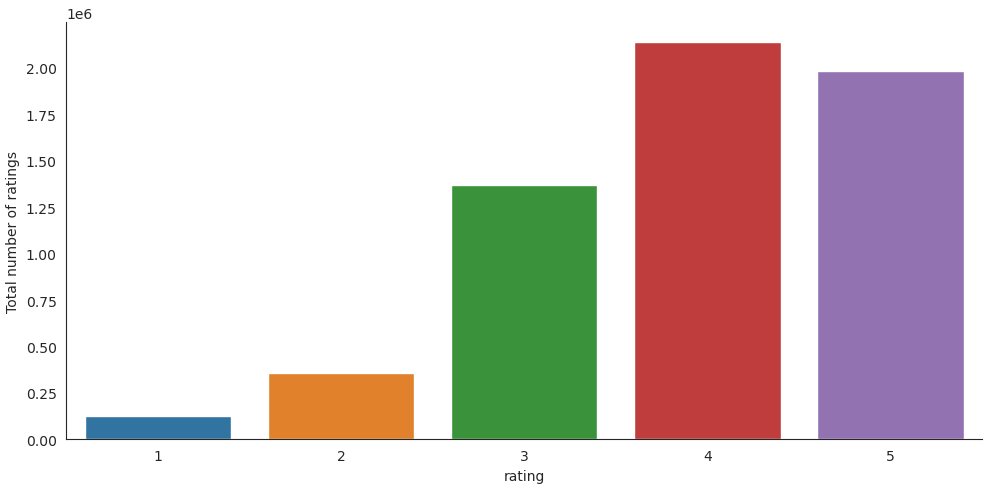

In [38]:
import seaborn as sns
import numpy as np


with sns.axes_style('white'):
    g = sns.catplot(data=book_ratings, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(book_ratings["rating"])}')

That's enough spelunking through our data. Let’s go ahead and make a recommendation system.

The first step is generating recommendations using content-based filtering.

## Content-based filtering 

### How it works 

<br></br>

<div align="center" style="width: 800px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Content_filtering.jpg"
     alt="Content-based Filtering"
     style="float: center; padding-bottom=0.5em"
     width=800px/>
A depiction of the decision process used to recommend items within content-based filtering algorithms.  
</div>

In Content-based filtering, we seek to make recommendations based on **how similar an item's properties or features are to those of other items.**

Let's use the image above to help us see how this works. Ebrahem is an avid reader who has just finished the novel "The Golden Compass". Besides the written contents inside this book (item), it has certain attributes or properties which further describe it - such as the author ("Philip Pullman"), genre ("fantasy"), or target audience ("young adult"). These properties are not unique to this novel, as other books also have authors, genres, target audiences, etc. As such, we can compare the properties of different books with the assumption that books which have properties in common (such as author or genre) are similar to one another. We can further **assume that individuals like similar items**. For our example, this means that Ebrahem, if using content-based filtering to recommend him next book, would have a book such as "Harry Potter and the Philosopher's Stone" suggested to him over Anne Frank's "The Diary of a Young Girl", as the former novel is far more 'similar' to The Golden Compass.     

So let's see how we would implement a system like this in real life.

### Implementation 

Let's implement a straightforward content filtering-based recommendation algorithm.

To begin, we need to gather the various properties of our items so that we can convert them into meaningful features. Following along from our example above, we're going to use the `tag_name` field for each book as a representation of properties such as genre, time-period, and target audience. We're also going to consider the `authors` field, as individuals often enjoy reading novels written by the same author. 

We start off by creating a new column in our `books` dataframe called `auth_tags`, which contains the above-motivated contents for each item. We additionally create two pandas series objects to help us translate between book titles and indexes of our dataframe.  

In [40]:
books['auth_tags'] = (pd.Series(books[['authors', 'tag_name']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

# Convenient indexes to map between book titles and indexes of 
# the books dataframe
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

In [41]:
indices['Harry Potter and the Half-Blood Prince (Harry Potter, #6)']

26

In [43]:
books.iloc[26]

book_id                                                                     27
goodreads_book_id_x                                                          1
best_book_id                                                                 1
work_id                                                               41335427
books_count                                                                275
isbn                                                                 439785960
isbn13                                                         9780439785970.0
authors                                            J.K. Rowling, Mary GrandPré
original_publication_year                                               2005.0
original_title                          Harry Potter and the Half-Blood Prince
title                        Harry Potter and the Half-Blood Prince (Harry ...
language_code                                                              eng
average_rating                                      

We now need a mechanism to convert these textual features into a format that enables us to compute their relative similarities. This will allow us to translate our string-based collection of tags and authors into numerical vectors (see [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for an overview of this process which is very similar to [count-based vectorization](https://youtu.be/W9VtEVBdgnQ)).

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tf_authTags_matrix = tf.fit_transform(books['auth_tags'])

We can now compute the similarity between each vector within our matrix. This is done by making use of the `cosine_similarity` function provided to us by `sklearn`.

In [61]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_authTags = cosine_similarity(tf_authTags_matrix, 
                                        tf_authTags_matrix)
print (cosine_sim_authTags.shape)

(10000, 10000)


In [62]:
cosine_sim_authTags[:5]

array([[1.        , 0.74398183, 0.92355189, ..., 0.20924068, 0.        ,
        0.        ],
       [0.74398183, 1.        , 0.70984673, ..., 0.20028835, 0.        ,
        0.        ],
       [0.92355189, 0.70984673, 1.        , ..., 0.23585502, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92578186, 0.71023653, 0.94735739, ..., 0.22650391, 0.        ,
        0.        ]])

The resulting structure is a $10000 \times 10000$ dense similarity matrix $S^I$, where the value of the entry in the $i^{th}$ row and $j^{th}$ column, $S^I_{i,j}$, corresponds to the similarity of books $i$ and $j$ within our dataset.

Using this notation, if $i$ and $j$ are the same number (i.e. all the diagonal entries in $S^I$), then the similarity value is equal to 1 (an item is completely similar to itself).  

#### Top-N recommendations

With our content similarity matrix computed, we're now ready to make some recommendations! Let's begin by generating a top-N list of books similar to the one which we prompt the system with.    

Following along from our earlier algorithmic explanation, we do this by: 

  1. Select an initial item (book) from which to generate recommendations. 
  2. Extract all the similarity values between the initial item and each other item in the similarity matrix.
  3. Sort the resulting values in descending order. 
  4. Select the top N similarity values and return the corresponding item details to the user. This is now our simple top-N list.  
  
We implement this algorithmic process in the function below:

In [63]:
def content_generate_top_N_recommendations(book_title, N=10):
    # Convert the string book title to a numeric index for our 
    # similarity matrix
    b_idx = indices[book_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_authTags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes 
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles 
    return titles.iloc[book_indices]

With our function defined, let's test our simple content-based recommender on some sample book titles:

In [64]:
content_generate_top_N_recommendations("The Hobbit", N=10)

18      The Fellowship of the Ring (The Lord of the Ri...
154            The Two Towers (The Lord of the Rings, #2)
160     The Return of the King (The Lord of the Rings,...
188     The Lord of the Rings (The Lord of the Rings, ...
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
4975         Unfinished Tales of Númenor and Middle-Earth
2308                                The Children of Húrin
610              The Silmarillion (Middle-Earth Universe)
8271                   The Complete Guide to Middle-Earth
Name: title, dtype: object

In [65]:
content_generate_top_N_recommendations("Romeo and Juliet", N=10)

8599                                         Train Dreams
1822            A Bear Called Paddington (Paddington, #1)
5754                     Valiant (Modern Faerie Tales #2)
3109    Dragon Ball, Vol. 1: The Monkey King (Dragon B...
27                                      Lord of the Flies
6750    The Declaration of Independence and The Consti...
4920                       Magic Rises (Kate Daniels, #6)
6747                                 Uganda Be Kidding Me
9790                                       A Window Opens
Name: title, dtype: object

In [66]:
content_generate_top_N_recommendations("The Diary of a Young Girl", N=10)

8027             Anne Frank's Tales from the Secret Annex
2942                                    The Weird Sisters
1895                            Pollyanna (Pollyanna, #1)
1919                                       The Luminaries
2099                   Batman: The Dark Knight Returns #1
2503    Sin City, Vol. 1: The Hard Goodbye (Sin City, #1)
3941    Sin City, Vol. 2: A Dame to Kill For (Sin City...
3994    Sin City, Vol. 4: That Yellow Bastard (Sin Cit...
8213    Sin City, Vol. 3: The Big Fat Kill (Sin City, #3)
Name: title, dtype: object

Having seen the results of these top-N lists, a couple of observations can be made. 

- First, our recommendations seem to be strongly centred around the author of the reference book. For example,  other works by Tolkien and are highly recommended when using reference searches for "The Hobbit". This could be a natural result of the fact that an author's name is far less common in the dataset than other textual features such as genre. As such, books which share an author will be regarded as being far more similar.  


 - Second, in cases where the reference author has not written multiple book titles, such as Anne Frank (The Diary of a Young Girl), the recommendations produced are more varied and cover multiple titles in the same or similar genres. 

 
Based on these observations, we can ask if, in fact, the recommendations for "The Hobbit" are actually any good. After all, a reader who knows of Tolkien will often already know of other books these authors have written as well. This is where some of the subjective metrics (such as diversity), can be used to penalize these recommendations and help discover better ones.